In [45]:
# importing dataprocessing functions
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import mixture
from scipy import linalg
import sklearn_extra

# Other library imports
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [33]:
def pre_process_iris(iris):    
    x = pd.DataFrame(iris.data, columns = ["Sepal Length","Sepal Width","Petal Length","Petal Width"])
    y = pd.DataFrame(iris.target, columns = ["Types"])
    return x, y

In [34]:
iris = load_iris()
x, y = pre_process_iris(iris)
x_standardized = StandardScaler().fit_transform(x)

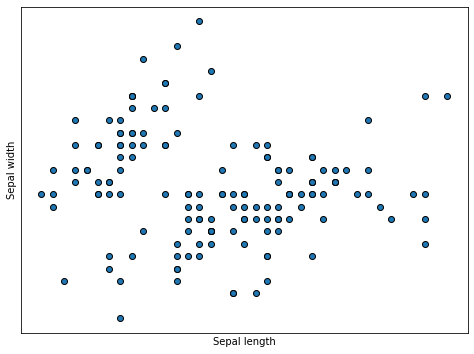

In [35]:
x_viz = x_standardized[:, :3]

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(x_viz[:, 0], x_viz[:, 1], cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xticks(())
plt.yticks(())
plt.show()

In [43]:
x_standardized.shape

(150, 4)

# Expectation Maximization with Gaussian Mixture Models

In [164]:
lowest_bic = np.infty
bic = []
n_components_range = range(3, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(x_standardized)
        bic.append(gmm.bic(x_standardized))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

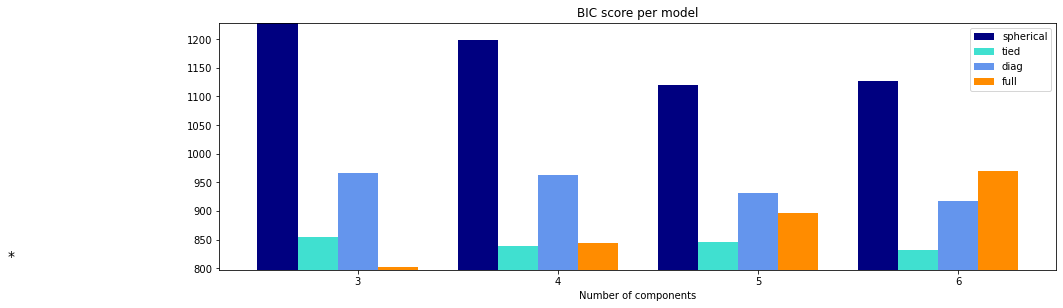

In [165]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 10))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

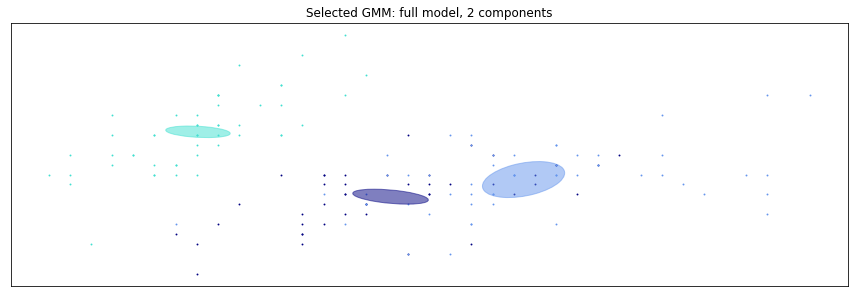

In [166]:
# Plot the winner
plt.figure(figsize=(15, 10))
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(x_standardized)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(x_standardized[Y_ == i, 0], x_standardized[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

# KMedoids

In [50]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

## With dimensional reduction before clustering

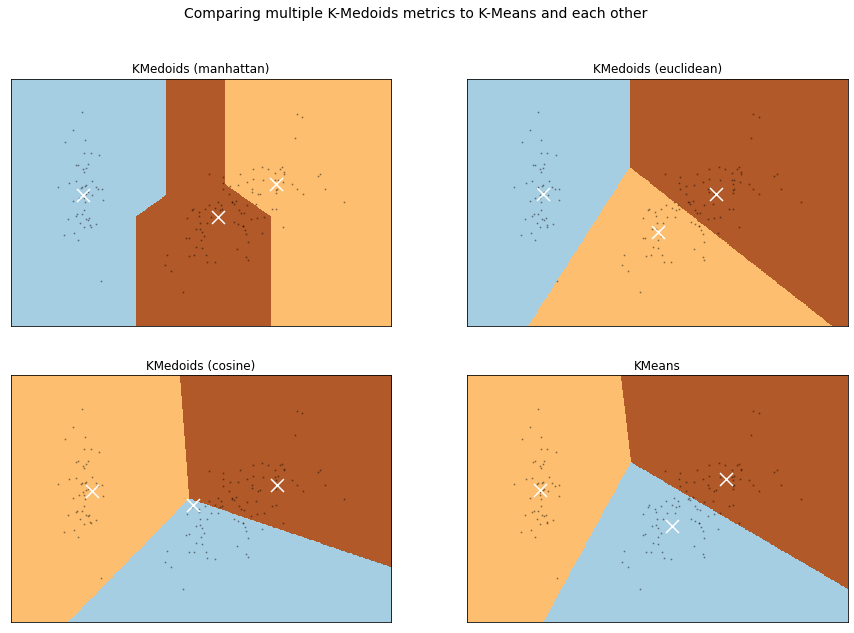

In [120]:
reduced_data = PCA(n_components=2).fit_transform(x_standardized)
n_digits = 3

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize=(15, 10))
plt.clf()

plt.suptitle(
    "Comparing multiple K-Medoids metrics to K-Means and each other",
    fontsize=14,
)


selected_models = [
    (
        KMedoids(metric="manhattan", n_clusters=n_digits),
        "KMedoids (manhattan)",
    ),
    (
        KMedoids(metric="euclidean", n_clusters=n_digits),
        "KMedoids (euclidean)",
    ),
    (KMedoids(metric="cosine", n_clusters=n_digits), "KMedoids (cosine)"),
    (KMeans(n_clusters=n_digits), "KMeans"),
]

plot_rows = int(np.ceil(len(selected_models) / 2.0))
plot_cols = 2

for i, (model, description) in enumerate(selected_models):

    # Obtain labels for each point in mesh. Use last trained model.
    model.fit(reduced_data)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.subplot(plot_cols, plot_rows, i + 1)
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(
        reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2, alpha=0.3
    )
    # Plot the centroids as a white X
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(description)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Without dimension reduction before clustering

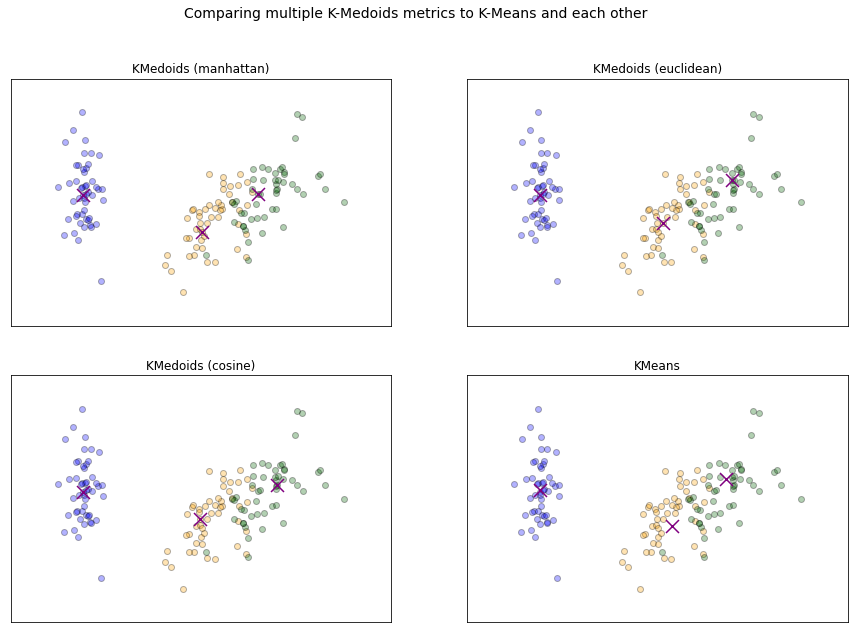

In [173]:
#reduced_data = PCA(n_components=2).fit_transform(x_standardized)
n_digits = 3

# Plot the decision boundary. For that, we will assign a color to each
plt.figure(figsize=(15, 10))
plt.clf()

plt.suptitle(
    "Comparing multiple K-Medoids metrics to K-Means and each other",
    fontsize=14,
)


selected_models = [
    (KMedoids(metric="manhattan", n_clusters=n_digits),"KMedoids (manhattan)",),
    (KMedoids(metric="euclidean", n_clusters=n_digits),"KMedoids (euclidean)",),
    (KMedoids(metric="cosine", n_clusters=n_digits), "KMedoids (cosine)"),
    (KMeans(n_clusters=n_digits), "KMeans"),
]

plot_rows = int(np.ceil(len(selected_models) / 2.0))
plot_cols = 2

for i, (model, description) in enumerate(selected_models):

    # Obtain labels for each point in mesh. Use last trained model.
    model.fit(x_standardized)

    PCA_model = PCA(n_components=2).fit(x_standardized)
    reduced_data = PCA_model.transform(x_standardized)
    
    plt.subplot(plot_cols, plot_rows, i + 1)
    for idx, item in enumerate(reduced_data):
        if y.iloc[idx].values[0]==0:
            col = "blue"
        elif y.iloc[idx].values[0]==1:
            col = "orange"
        else:
            col = "darkgreen"
        plt.plot(
            item[0], item[1], "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=6, 
            alpha=0.3
        )
        
    # Plot the centroids as a purple X
    reduced_centroids = PCA_model.transform(model.cluster_centers_)
    plt.scatter(
        reduced_centroids[:, 0],
        reduced_centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="purple",
        zorder=10,
    )
    plt.title(description)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

plt.show()

# In 3D

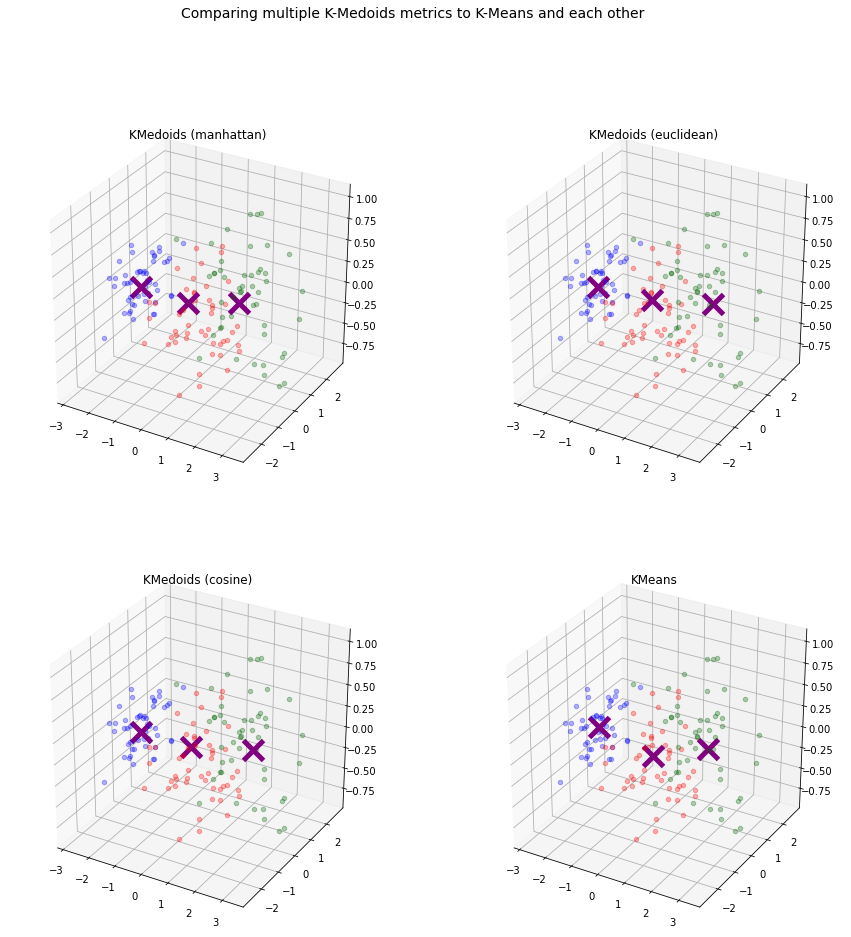

In [174]:
#reduced_data = PCA(n_components=2).fit_transform(x_standardized)
n_digits = 3

# Plot the decision boundary. For that, we will assign a color to each
fig = plt.figure(figsize=(15, 15))
fig.suptitle(
    "Comparing multiple K-Medoids metrics to K-Means and each other",
    fontsize=14,
)


selected_models = [
    (KMedoids(metric="manhattan", n_clusters=n_digits),"KMedoids (manhattan)",),
    (KMedoids(metric="euclidean", n_clusters=n_digits),"KMedoids (euclidean)",),
    (KMedoids(metric="cosine", n_clusters=n_digits), "KMedoids (cosine)"),
    (KMeans(n_clusters=n_digits), "KMeans"),
]

plot_rows = int(np.ceil(len(selected_models) / 2.0))
plot_cols = 2

for i, (model, description) in enumerate(selected_models):

    # Obtain labels for each point in mesh. Use last trained model.
    model.fit(x_standardized)
    
    PCA_model = PCA(n_components=3).fit(x_standardized)
    reduced_data = PCA_model.transform(x_standardized)
    
    ax = fig.add_subplot(plot_cols, plot_rows, i + 1, projection='3d')
    #plt.subplot(plot_cols, plot_rows, i + 1, projection='3d')
    for idx, item in enumerate(reduced_data):
        if y.iloc[idx].values[0]==0:
            col = "blue"
        elif y.iloc[idx].values[0]==1:
            col = "red"
        else:
            col = "darkgreen"
        ax.scatter(
            item[0], item[1], item[2],
            marker="o", color = col, alpha=0.3
        )
        
    # Plot the centroids as a purple X
    reduced_centroids = PCA_model.transform(model.cluster_centers_)
    for cent in reduced_centroids:
        ax.scatter(
            cent[0],
            cent[1],
            cent[2],
            marker="x",
            color="purple",
            linewidth=5,
            s=400
        )
    plt.title(description)

plt.show()